In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_context('paper')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle("data/lbc_pandas.pkl")

In [24]:
# prepare the grid search
rmr_params={'n_estimators':[10,50,100],
            'max_features':range(1,7),
            'min_samples_split':[2,4]}
grid = GridSearchCV(RandomForestRegressor(oob_score=True),cv=3,param_grid=rmr_params)

# prepare the dataset
careof = ['Surface','Arrondissement','Meuble_int','weekday','ins_hour','Ges_int','ClasseEnergie_int']
ylbl   = ['LoyerMensuel',]
z = df[careof+ylbl].dropna()
x = z[careof]
y = z[ylbl[0]]

In [25]:
_=grid.fit(x,y);

In [5]:
rmr = grid.best_estimator_
print grid.best_params_
print grid.best_score_

{'max_features': 2, 'min_samples_split': 4, 'n_estimators': 100}
0.414453768472


In [6]:
print cross_val_score(rmr,x,y).mean()
# rmr.fit(x,y)
features_importance = { n:y for n,y in zip(careof,rmr.feature_importances_)}
ymax = np.sum(features_importance.values())

for k,v in features_importance.iteritems():
    print "{0:20s}| {1:5.1f}%".format(k,v/ymax*100)


0.407911790303
Arrondissement      |  20.7%
Surface             |  42.4%
ins_hour            |  11.5%
weekday             |   6.3%
Meuble_int          |   3.7%
ClasseEnergie_int   |   8.3%
Ges_int             |   7.0%


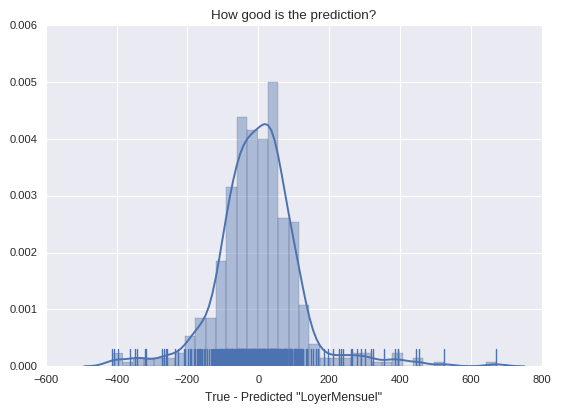

In [7]:
sns.distplot(y-rmr.predict(x),rug=1)
sns.plt.title('How good is the prediction?')
sns.plt.gca().set_xlabel('True - Predicted "LoyerMensuel"')

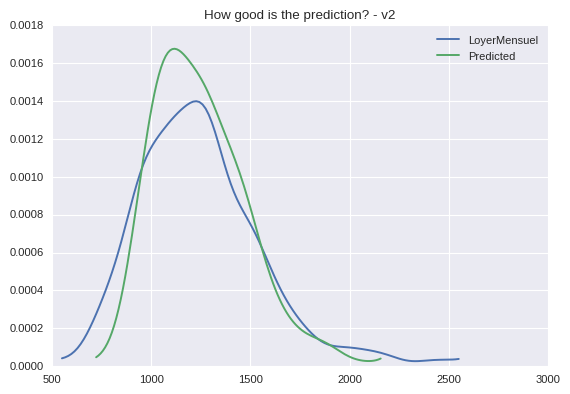

In [23]:
bw = 80
sns.kdeplot(y,cut=0,bw=bw)
sns.kdeplot(rmr.predict(x),cut=0,bw=bw,label="Predicted")
sns.plt.title('How good is the prediction? - v2')

In [8]:
def forecastFeatureDynamics(g,rows=24,field=4):
    x=g.values
#     print x
#     return 0
    egys=[]
    field = 4
    for i in range(len(x)):
        eg = x[i].copy()
        h0 = int(eg[field])
        cols = eg.shape[0]
        eg = np.tile(eg,rows).reshape(rows,cols)
        eg[:,field]=np.arange(0,rows)
        egy = rmr.predict(eg)
        eg0 = egy[h0]
    #     print egy/eg0
        egys.append(egy/eg0)
    #     sns.plt.plot(eg[:,4],egy/eg0,'-')
    one = np.mean(egys,axis=0)
    two = np.std(egys,ddof=1,axis=0)/len(egys)**.5
    return {'h_':np.arange(0,24), 'mean_':one,'std_':two}
pex = x.groupby('Arrondissement').apply(forecastFeatureDynamics)

/home/astyonax/.anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/astyonax/.anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


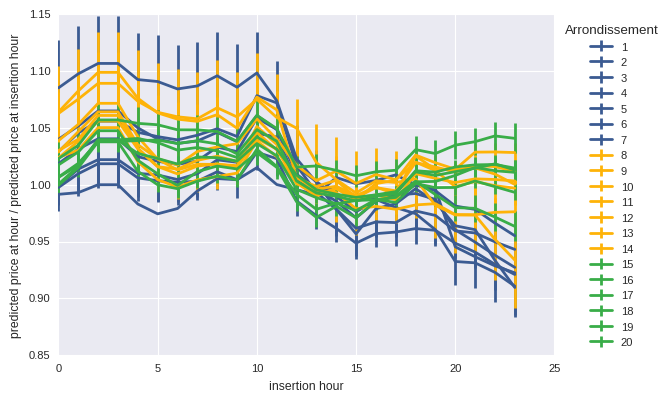

In [9]:
# palette = (i for i in sns.color_palette('coolwarm_r',21))
colors = [sns.xkcd_rgb["denim blue"],
sns.xkcd_rgb["amber"],
sns.xkcd_rgb["medium green"]]
palette = (i for i in np.repeat(colors,21/3))

for k,v in pex.to_dict().iteritems():
    _x=v['h_']
    _y=v['mean_']
    _ye=v['std_']

    sns.plt.errorbar(_x,_y,yerr=_ye,label='{0:d}'.format(k),color=palette.next(),lw=2)
sns.plt.legend(bbox_to_anchor=(1, 1), loc='upper left',title='Arrondissement')
sns.plt.xlabel('insertion hour')
sns.plt.ylabel('predicted price at hour / predicted price at insertion hour')